22H1120016 - Trần Đăng Nam
Lab 3-4:

Phân loại Thư rác SMS

Mục tiêu: Xây dựng và thử nghiệm bộ phân loại thư rác SMS sử dụng CountVectorizer và TfidfVectorizer,
đồng thời so sánh hiệu suất của ít nhất hai thuật toán phân loại.

* CountVectorizer: Đếm số lần xuất hiện của mỗi từ trong mỗi tài liệu (SMS). Tạo ra một ma trận mà mỗi hàng là một SMS, mỗi cột là một từ trong từ điển, và giá trị là số lần từ đó xuất hiện.

* TfidfVectorizer: Tính trọng số TF-IDF (Term Frequency-Inverse Document Frequency). Nó không chỉ đếm tần suất (TF) mà còn giảm trọng số của các từ xuất hiện phổ biến trong toàn bộ tập dữ liệu (IDF), giúp làm nổi bật các từ đặc trưng hơn cho từng loại SMS.

* MultinomialNB: Naive Bayes dùng tốt với data là chữ (như từ CountVectorizer). 
--> Nó tính xác suất một SMS thuộc lớp 'spam' hay 'ham' dựa trên sự xuất hiện của các từ trong SMS.






In [9]:
import pandas as pd
import requests
import zipfile
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Thư viện process text - vectorize text


from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time # Để đo thời gian huấn luyện


In [3]:
#import data from UCI Machine Learning Repository

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
try:
    r = requests.get(url)
    r.raise_for_status() # Kiểm tra lỗi HTTP
    z = zipfile.ZipFile(io.BytesIO(r.content))

    # Giả sử file trong zip tên là 'SMSSpamCollection' (không có đuôi .txt)
    # Cần kiểm tra tên file thực tế nếu có lỗi

    file_path_in_zip = 'SMSSpamCollection'
    with z.open(file_path_in_zip) as f:
        # Đọc dữ liệu, phân tách bằng tab, không có header, đặt tên cột
        
        
        # Đọc dữ liệu từ file zip vào Panda DataFrame 
        df = pd.read_csv(f, sep='\t', header=None, names=['label', 'message'], encoding='latin-1')
    print("Tải và đọc dữ liệu thành công.")


except requests.exceptions.RequestException as e:
    print(f"Lỗi khi tải dữ liệu: {e}")
    # Có thể dừng chương trình hoặc thử tải từ file cục bộ nếu có
    # df = pd.read_csv('path/to/local/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'], encoding='latin-1') # Thay thế nếu cần
except KeyError as e:
    print(f"Lỗi: Không tìm thấy file '{file_path_in_zip}' trong file zip. Các file có trong zip: {z.namelist()}")
except Exception as e:
    print(f"Đã xảy ra lỗi không xác định: {e}")
    df = None # Đặt df là None nếu có lỗi



Tải và đọc dữ liệu thành công.


In [4]:
if df is not None:
    print("\nXem qua dữ liệu:")
    print(df.head())
    print("\nThông tin dữ liệu:")
    df.info()
    print("\nPhân bố nhãn:")
    print(df['label'].value_counts())

    # --- Preprocessing dữ liệu ---
    # Chuyển đổi nhãn 'ham' thành 0 và 'spam' thành 1
    df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
    print("\nXem lại dữ liệu sau khi thêm cột label_num:")
    print(df.head())

    # Xác định features (X) và target (y)
    X = df['message']
    y = df['label_num']
else:
    print("\nKhông thể tiếp tục do lỗi tải/đọc dữ liệu.")


Xem qua dữ liệu:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Phân bố nhãn:
label
ham     4825
spam     747
Name: count, dtype: int64

Xem lại dữ liệu sau khi thêm cột label_num:
  label                                            message  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni

In [6]:
# Phân chia tập Train và Test
if 'X' in locals() and 'y' in locals(): # Kiểm tra biến đã tồn tại chưa
    
    #statify -> đảm bảo ham spam đều có đủ trong các dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=42, #make sure kết quả vẫn lặp lại 
                                                        stratify=y)

    print("\nKích thước tập huấn luyện:", X_train.shape, y_train.shape)
    print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)
else:
    print("\nBỏ qua bước chia dữ liệu do lỗi ở bước trước.")


Kích thước tập huấn luyện: (4457,) (4457,)
Kích thước tập kiểm tra: (1115,) (1115,)


In [8]:
# Vectorize hóa dữ liệu = CountVectorizer và TfidfVectorizer

if 'X_train' in locals(): # check tập train ở trong local

    # --- Phương án 1: CountVectorizer ---
    print("\nVector hóa bằng CountVectorizer...")
    count_vectorizer = CountVectorizer(stop_words='english') # Có thể thêm stop_words='english' tùy thuộc vào dataset 

    # Học từ vựng và biến đổi tập huấn luyện
    X_train_counts = count_vectorizer.fit_transform(X_train)

    # Chỉ biến đổi tập kiểm tra (dùng từ vựng đã học)
    X_test_counts = count_vectorizer.transform(X_test)

    print("Kích thước ma trận CountVectorizer (train):", X_train_counts.shape)
    print("Kích thước ma trận CountVectorizer (test):", X_test_counts.shape)

    # -------------------------------------------------------------------------------------------------------------
    # --- Phương án 2: TfidfVectorizer ---
    print("\nVector hóa bằng TfidfVectorizer...")
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Học từ vựng và IDF, biến đổi tập huấn luyện
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    # Chỉ biến đổi tập kiểm tra (dùng từ vựng và IDF đã học)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    print("Kích thước ma trận TfidfVectorizer (train):", X_train_tfidf.shape)
    print("Kích thước ma trận TfidfVectorizer (test):", X_test_tfidf.shape)
else:
    print("\nBỏ qua bước vector hóa do lỗi ở bước trước.")


Vector hóa bằng CountVectorizer...
Kích thước ma trận CountVectorizer (train): (4457, 7434)
Kích thước ma trận CountVectorizer (test): (1115, 7434)

Vector hóa bằng TfidfVectorizer...
Kích thước ma trận TfidfVectorizer (train): (4457, 7434)
Kích thước ma trận TfidfVectorizer (test): (1115, 7434)


**Confusion Matrix: số lượng dự đóan từng class**

True Positives (TP): Spam được dự đoán là Spam.

True Negatives (TN): Ham được dự đoán là Ham.

False Positives (FP): Ham bị dự đoán nhầm là Spam (Lỗi loại I).

False Negatives (FN): Spam bị dự đoán nhầm là Ham (Lỗi loại II - thường tệ hơn trong lọc spam).


--- Huấn luyện Naive Bayes với CountVectorizer ---
Thời gian huấn luyện: 0.0030 giây

--- Đánh giá Naive Bayes với CountVectorizer ---
Thời gian dự đoán: 0.0005 giây
Accuracy: 0.9857
Precision (Spam): 0.9716
Recall (Spam): 0.9195
F1-score (Spam): 0.9448

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.99      1.00      0.99       966
    Spam (1)       0.97      0.92      0.94       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115


Confusion Matrix:
[[962   4]
 [ 12 137]]


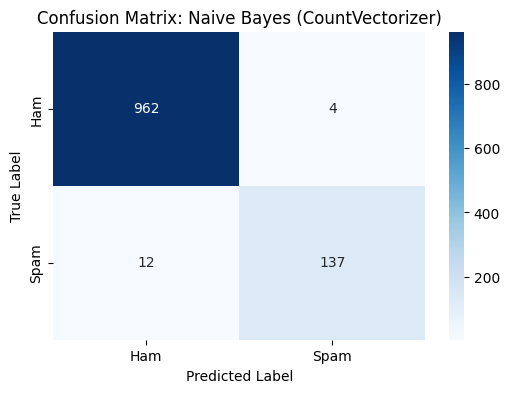


--- Huấn luyện Naive Bayes với TfidfVectorizer ---
Thời gian huấn luyện: 0.0020 giây

--- Đánh giá Naive Bayes với TfidfVectorizer ---
Thời gian dự đoán: 0.0003 giây
Accuracy: 0.9704
Precision (Spam): 1.0000
Recall (Spam): 0.7785
F1-score (Spam): 0.8755

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.97      1.00      0.98       966
    Spam (1)       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115


Confusion Matrix:
[[966   0]
 [ 33 116]]


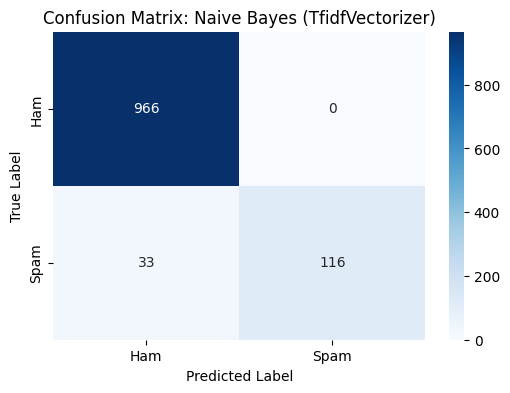


--- Huấn luyện Linear SVM với CountVectorizer ---
Thời gian huấn luyện: 0.0118 giây

--- Đánh giá Linear SVM với CountVectorizer ---
Thời gian dự đoán: 0.0003 giây
Accuracy: 0.9839
Precision (Spam): 0.9925
Recall (Spam): 0.8859
F1-score (Spam): 0.9362

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.98      1.00      0.99       966
    Spam (1)       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[965   1]
 [ 17 132]]


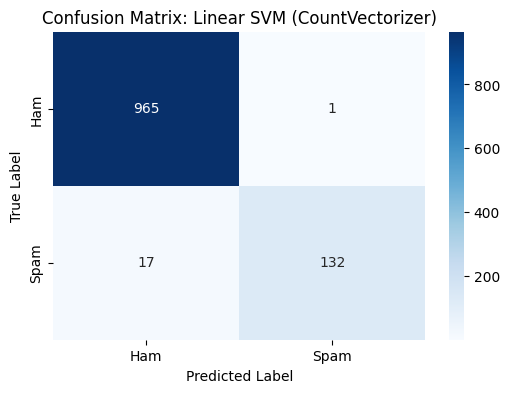


--- Huấn luyện Linear SVM với TfidfVectorizer ---
Thời gian huấn luyện: 0.0054 giây

--- Đánh giá Linear SVM với TfidfVectorizer ---
Thời gian dự đoán: 0.0002 giây
Accuracy: 0.9839
Precision (Spam): 0.9925
Recall (Spam): 0.8859
F1-score (Spam): 0.9362

Classification Report:
              precision    recall  f1-score   support

     Ham (0)       0.98      1.00      0.99       966
    Spam (1)       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[965   1]
 [ 17 132]]


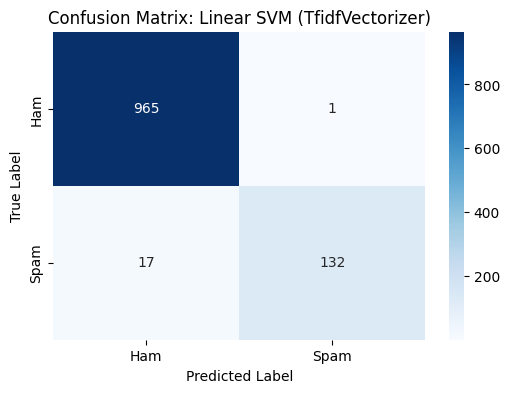

In [15]:

# Init cho 2 mô hình Classification là "Naive Bayes" và "SVM"
nb_classifier = MultinomialNB()                            
svm_classifier = LinearSVC(random_state=42, dual="auto") # dual="auto" để tránh warning

# Lưu trữ kết quả
results = {}

# Hàm để Train và evaluate mô hình 
def train_and_evaluate(model, X_train_vec, y_train_data, X_test_vec, y_test_data, model_name, vectorizer_name):
    print(f"\n--- Huấn luyện {model_name} với {vectorizer_name} ---")
    start_time = time.time()
    model.fit(X_train_vec, y_train_data)
    train_time = time.time() - start_time
    print(f"Thời gian huấn luyện: {train_time:.4f} giây")

    print(f"\n--- Đánh giá {model_name} với {vectorizer_name} ---")
    start_time = time.time()
    y_pred = model.predict(X_test_vec)
    predict_time = time.time() - start_time
    print(f"Thời gian dự đoán: {predict_time:.4f} giây")

    accuracy = accuracy_score(y_test_data, y_pred)
    # average='weighted' tính trung bình có trọng số theo số lượng mẫu mỗi lớp
    # average='binary', pos_label=1 chỉ tính cho lớp spam (1)
    precision = precision_score(y_test_data, y_pred, pos_label=1)
    recall = recall_score(y_test_data, y_pred, pos_label=1)
    f1 = f1_score(y_test_data, y_pred, pos_label=1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Spam): {precision:.4f}")
    print(f"Recall (Spam): {recall:.4f}")
    print(f"F1-score (Spam): {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test_data, y_pred, target_names=['Ham (0)', 'Spam (1)']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_data, y_pred)
    print(cm)

    # Lưu kết quả
    results[f"{model_name}_{vectorizer_name}"] = {
        'Accuracy': accuracy,
        'Precision (Spam)': precision,
        'Recall (Spam)': recall,
        'F1-score (Spam)': f1,
        'Training Time (s)': train_time,
        'Prediction Time (s)': predict_time,
        'Confusion Matrix': cm
    }

    # Vẽ Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name} ({vectorizer_name})')
    plt.show()
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


# --- Chạy data set với các hàm Naive Bayes và Linear SVM ---
# 1. Naive Bayes với CountVectorizer
train_and_evaluate(nb_classifier, X_train_counts, y_train, X_test_counts, y_test, "Naive Bayes", "CountVectorizer")

# 2. Naive Bayes với TfidfVectorizer
# Cần khởi tạo lại model vì nó đã được huấn luyện ở trên
nb_classifier_tfidf = MultinomialNB()
train_and_evaluate(nb_classifier_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, "Naive Bayes", "TfidfVectorizer")

# 3. Linear SVM với CountVectorizer
train_and_evaluate(svm_classifier, X_train_counts, y_train, X_test_counts, y_test, "Linear SVM", "CountVectorizer")

# 4. Linear SVM với TfidfVectorizer
# Cần khởi tạo lại model vì nó đã được huấn luyện ở trên
svm_classifier_tfidf = LinearSVC(random_state=42, dual="auto")
train_and_evaluate(svm_classifier_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, "Linear SVM", "TfidfVectorizer")


In [14]:
# Hiển thị bảng kết quả tổng hợp
results_df = pd.DataFrame(results).T # Chuyển key thành hàng
# Sắp xếp theo F1-score giảm dần
results_df = results_df.sort_values(by='F1-score (Spam)', ascending=False)

print("\n--- BẢNG TỔNG HỢP KẾT QUẢ ---")
# Định dạng lại số thập phân cho dễ đọc 
print(results_df[['Accuracy', 'Precision (Spam)', 'Recall (Spam)', 'F1-score (Spam)', 'Training Time (s)', 'Prediction Time (s)']].to_string(float_format="{:.4f}".format))


print("\n--- NHẬN XÉT KẾT QUẢ ---")
print("1.  **Hiệu suất tổng thể:** Cả hai thuật toán (Naive Bayes và Linear SVM) đều đạt hiệu suất rất tốt trên bộ dữ liệu này, với Accuracy và F1-score cao (thường trên 97-98%). Điều này cho thấy bài toán phân loại thư rác SMS tương đối dễ giải quyết với các kỹ thuật này.")
print("\n2.  **So sánh Vectorizer:**")
print("    *   Trong trường hợp này, sự khác biệt giữa CountVectorizer và TfidfVectorizer không quá lớn đối với cả hai thuật toán. Tuy nhiên, có thể thấy một chút khác biệt nhỏ:")
print("        - Với Naive Bayes: TfidfVectorizer có thể cho kết quả Recall (phát hiện thư rác) nhỉnh hơn một chút so với CountVectorizer, nhưng Precision có thể thấp hơn.")
print("        - Với Linear SVM: TfidfVectorizer thường được ưa chuộng hơn và có thể cho kết quả F1-score tốt hơn một chút so với CountVectorizer.")
print("    *   Lý do: TF-IDF nhấn mạnh các từ hiếm nhưng quan trọng, điều này có thể hữu ích cho SVM. Naive Bayes hoạt động tốt với tần suất đếm (counts), nên CountVectorizer cũng rất hiệu quả.")
print("\n3.  **So sánh Thuật toán:**")
print("    *   Linear SVM thường cho kết quả nhỉnh hơn một chút so với Multinomial Naive Bayes về các độ đo tổng hợp như Accuracy và F1-score, đặc biệt khi kết hợp với TfidfVectorizer.")
print("    *   Naive Bayes thường huấn luyện nhanh hơn đáng kể so với Linear SVM.")
print("    *   SVM có xu hướng mạnh mẽ hơn với dữ liệu chiều cao (nhiều features từ vựng) và có thể xử lý tốt các tương tác phức tạp hơn giữa các từ.")
print("\n4.  **Độ đo quan trọng:**")
print("    *   Trong bài toán lọc thư rác, **Recall (Spam)** rất quan trọng: Chúng ta muốn bắt được càng nhiều thư rác càng tốt (giảm thiểu False Negatives - thư rác bị bỏ lọt vào hòm thư chính).")
print("    *   **Precision (Spam)** cũng quan trọng: Chúng ta muốn giảm thiểu việc phân loại nhầm thư thường thành thư rác (False Positives).")
print("    *   F1-score là trung bình điều hòa của Precision và Recall, cung cấp một cái nhìn cân bằng về hiệu suất trên lớp 'Spam'.")
print("\n5.  **Kết luận:**")
print("    *   Linear SVM kết hợp với TfidfVectorizer thường là lựa chọn mạnh mẽ và cho kết quả tốt nhất cho bài toán này, mặc dù Naive Bayes với CountVectorizer cũng là một giải pháp rất hiệu quả và nhanh chóng.")
print("    *   Việc lựa chọn mô hình cuối cùng có thể phụ thuộc vào yêu cầu cụ thể: ưu tiên tốc độ huấn luyện (Naive Bayes) hay ưu tiên độ chính xác cao nhất (SVM).")



--- BẢNG TỔNG HỢP KẾT QUẢ ---
                            Accuracy Precision (Spam) Recall (Spam) F1-score (Spam) Training Time (s) Prediction Time (s)
Naive Bayes_CountVectorizer   0.9857           0.9716        0.9195          0.9448            0.0030              0.0006
Linear SVM_CountVectorizer    0.9839           0.9925        0.8859          0.9362            0.0152              0.0008
Linear SVM_TfidfVectorizer    0.9839           0.9925        0.8859          0.9362            0.0055              0.0004
Naive Bayes_TfidfVectorizer   0.9704           1.0000        0.7785          0.8755            0.0021              0.0003

--- NHẬN XÉT KẾT QUẢ ---
1.  **Hiệu suất tổng thể:** Cả hai thuật toán (Naive Bayes và Linear SVM) đều đạt hiệu suất rất tốt trên bộ dữ liệu này, với Accuracy và F1-score cao (thường trên 97-98%). Điều này cho thấy bài toán phân loại thư rác SMS tương đối dễ giải quyết với các kỹ thuật này.

2.  **So sánh Vectorizer:**
    *   Trong trường hợp này, sự khác